<a href="https://colab.research.google.com/github/Geringer13/Netology_pyda/blob/master/Final_work_Creating_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Item_Identifier - Id продукта

Item_Weight - Вес продукта

Item_Fat_Content - Содержание жира в продукте

Item_Visibility - %полок, отведенный под наш продукт в конкретном магазине

Item_Type - Категория продукта

Item_MRP - Максимальная цена продажи продукта

Outlet_Identifier - Идентификатор магазина

Outlet_Establishment_Year - Год открытия магазина

Outlet_Size - Площадь магазина

Outlet_Location_Type - Тип города, в котором расположен магазин

Outlet_Type - Признак является ли магазин продуктовым или супермаркетом

Item_Outlet_Sales - Продажи продукта в конкретном магазине. Именно ее и надо предсказывать


**Read the file**

In [4]:
data = pd.read_csv('data.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Explore dataset with info, describe etc**

In [0]:
len(data)

8523

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [0]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [0]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


**We have two columns with NaN values, its Weight and Size. Let`s deal with this, I suggest fill weight NaN values with mean(), and size NaN values transform into 4th feature of a size type.**

Process size feature

In [0]:
# Let`s make 4th feature - another type
data['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

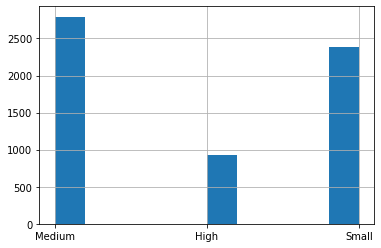

In [0]:
data['Outlet_Size'].hist()

In [0]:
data['Outlet_Size'] = data['Outlet_Size'].fillna('Another')

Medium     2793
Another    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64


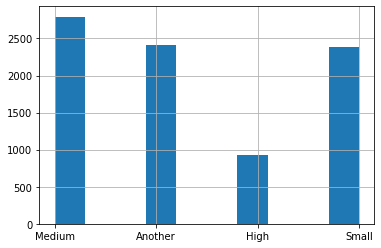

In [165]:
data['Outlet_Size'].hist()
print(data['Outlet_Size'].value_counts())

Process weight feature, fill NaN values with mean() according to a item type 

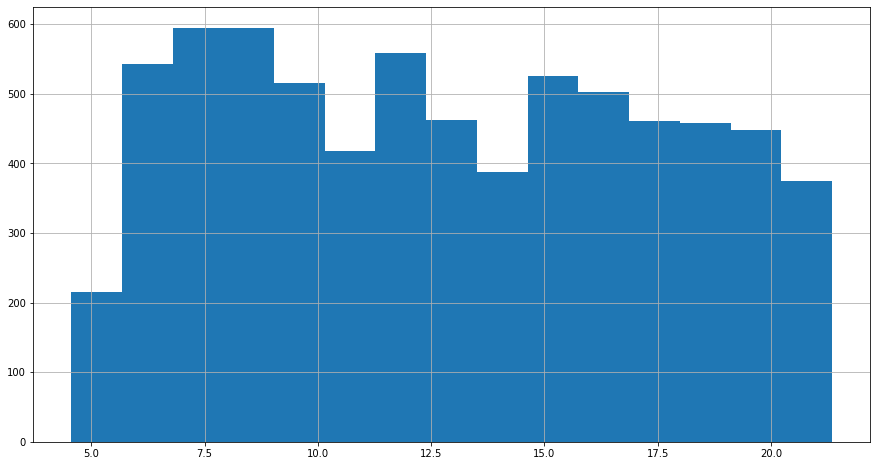

In [0]:
plt.figure(figsize=(15,8))
data['Item_Weight'].hist(bins=15)
plt.show()

In [0]:
# we see that amounts of NaN weight valeus equal 1463 records, its huge number

print(data['Item_Weight'].value_counts())
print(data['Item_Weight'].isna().sum())

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.560      2
9.420      1
5.400      1
6.520      1
7.685      1
Name: Item_Weight, Length: 415, dtype: int64
1463


In [0]:
data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [0]:
# let`s fill NAN values with the mode values for each type
# first of all estimate mode values for each type and put it in new dataframe
mode = data.groupby('Item_Type').apply(lambda data: data['Item_Weight'].mode())

In [8]:
mode = pd.DataFrame(mode)
mode = mode.reset_index()
mode.head()

,Item_Type,level_1,0
0,Baking Goods,0,9.800
1,Breads,0,15.850
2,Breakfast,0,7.895
3,Canned,0,13.000
4,Canned,1,19.500


In [0]:
mode = mode.drop('level_1', axis=1)

In [10]:
mode.columns = ['Item_Type', 'Mode']
mode

,Item_Type,Mode
0,Baking Goods,9.800
1,Breads,15.850
2,Breakfast,7.895
3,Canned,13.000
4,Canned,19.500
5,Dairy,20.700
6,Frozen Foods,13.650
7,Fruits and Vegetables,18.200
8,Hard Drinks,9.300
9,Hard Drinks,18.850


In [11]:
# merge general dataframe with mode
data = data.merge(mode, how='left')
data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Mode
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,20.70
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,14.15
2,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,15.35
3,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,11.80
4,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Another,Tier 3,Grocery Store,732.3800,18.20
5,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,20.20
6,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088,9.80
7,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,17.60
8,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,17.60
9,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Another,Tier 2,Supermarket Type1,1076.5986,13.65


In [0]:
data['Item_Weight'] = data['Item_Weight'].fillna('nothing')

In [0]:
data.loc[data['Item_Weight']=='nothing', 'Item_Weight'] = data['Mode']

In [0]:
data = data.drop('Mode', axis=1)

In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9831 entries, 0 to 9830
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            9831 non-null   object 
 1   Item_Weight                9831 non-null   object 
 2   Item_Fat_Content           9831 non-null   object 
 3   Item_Visibility            9831 non-null   float64
 4   Item_Type                  9831 non-null   object 
 5   Item_MRP                   9831 non-null   float64
 6   Outlet_Identifier          9831 non-null   object 
 7   Outlet_Establishment_Year  9831 non-null   int64  
 8   Outlet_Size                9831 non-null   object 
 9   Outlet_Location_Type       9831 non-null   object 
 10  Outlet_Type                9831 non-null   object 
 11  Item_Outlet_Sales          9831 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 1.3+ MB


Nice, we have filled all nan values, lets research our data

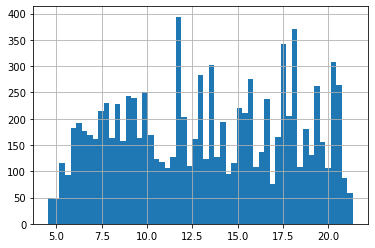

In [203]:
# let`s look for different distributions
data['Item_Weight'].hist(bins=55)

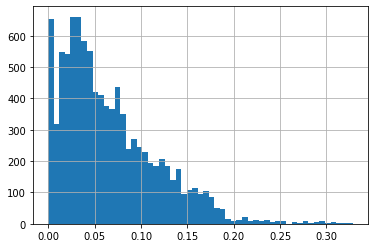

In [208]:
data['Item_Visibility'].hist(bins=55)

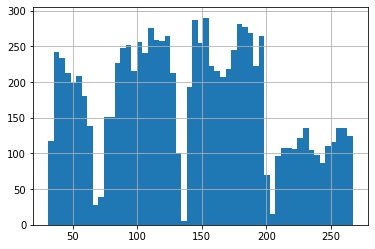

In [209]:
data['Item_MRP'].hist(bins=55)

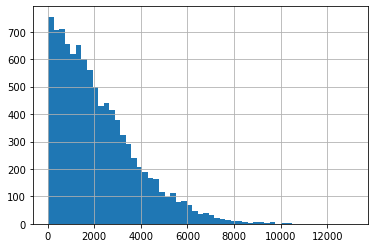

In [210]:
data['Item_Outlet_Sales'].hist(bins=55)

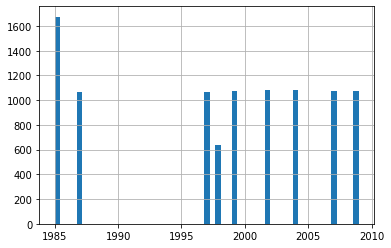

In [227]:
data['Outlet_Establishment_Year'].hist(bins=55)

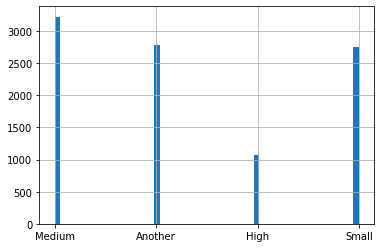

In [228]:
data['Outlet_Size'].hist(bins=55)

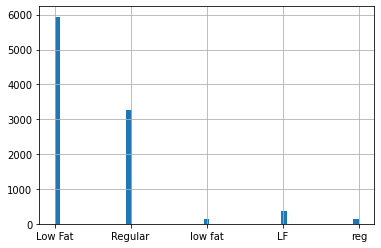

In [229]:
data['Item_Fat_Content'].hist(bins=55)

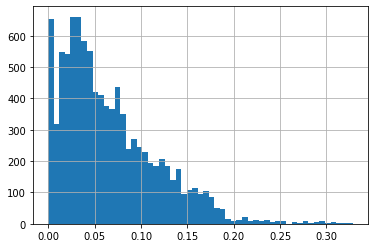

In [230]:
data['Item_Visibility'].hist(bins=55)

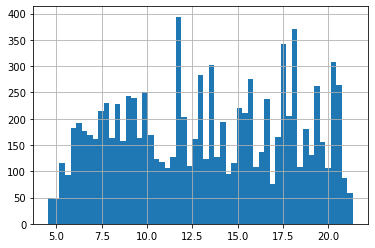

In [231]:
data['Item_Weight'].hist(bins=55)

In [0]:
# look at sales rating according to different features
sales = data.groupby('Item_Type').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

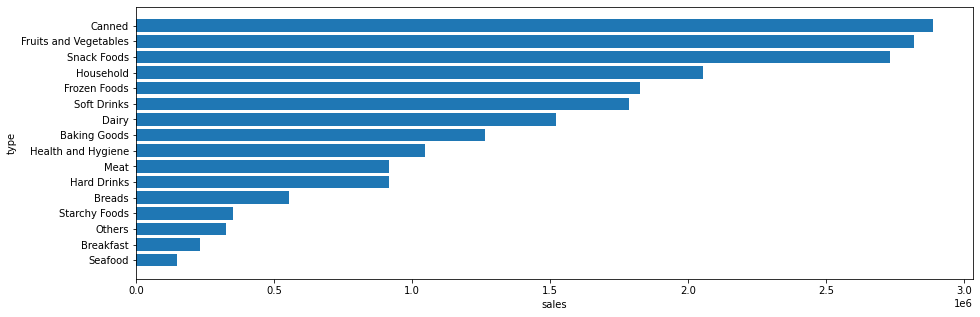

In [214]:
plt.figure(figsize=(15,5))
plt.barh(sales['Item_Type'], sales['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.ylabel('type')
plt.show()

In [0]:
sales2 = data.groupby('Item_Fat_Content').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

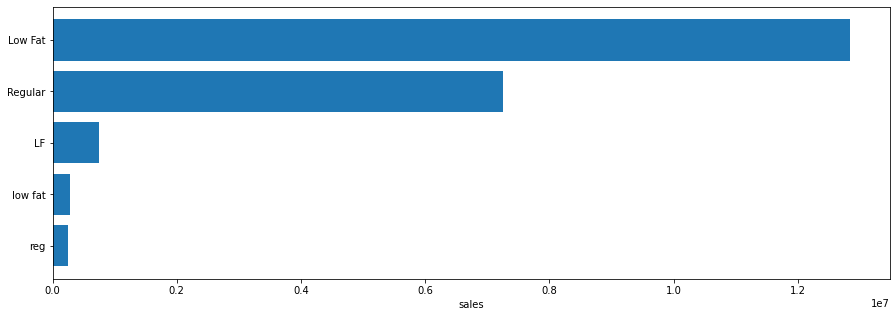

In [219]:
plt.figure(figsize=(15,5))
plt.barh(sales2['Item_Fat_Content'], sales2['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.show()

In [0]:
sales3 = data.groupby('Outlet_Size').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

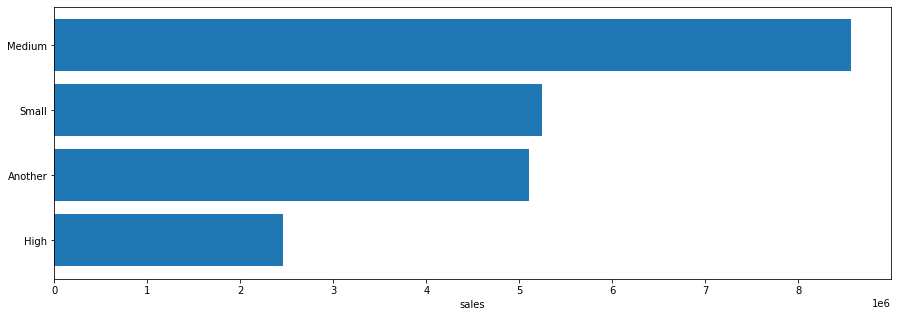

In [222]:
plt.figure(figsize=(15,5))
plt.barh(sales3['Outlet_Size'], sales3['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.show()

In [0]:
sales4 = data.groupby('Outlet_Identifier').sum().sort_values('Item_Outlet_Sales', ascending=True).reset_index()

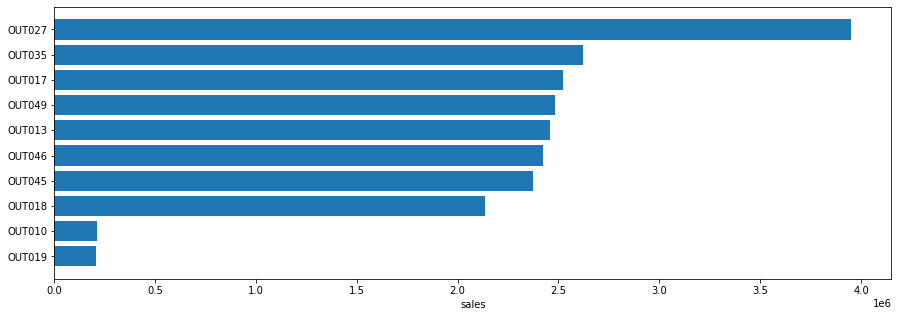

In [226]:
plt.figure(figsize=(15,5))
plt.barh(sales4['Outlet_Identifier'], sales4['Item_Outlet_Sales'])
plt.xlabel('sales')
plt.show()

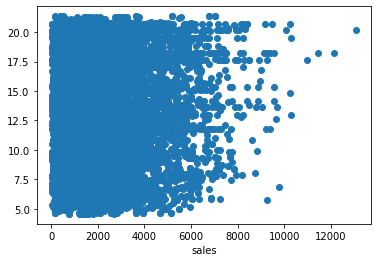

In [232]:
# lets look at sales correlation with different features

plt.scatter(data['Item_Outlet_Sales'], data['Item_Weight'])
plt.xlabel('sales')
plt.show()

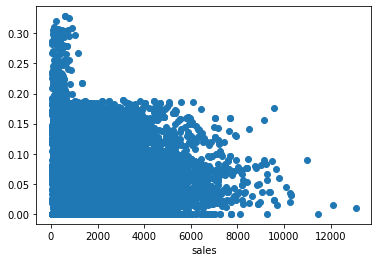

In [234]:
plt.scatter(data['Item_Outlet_Sales'], data['Item_Visibility'])
plt.xlabel('sales')
plt.show()

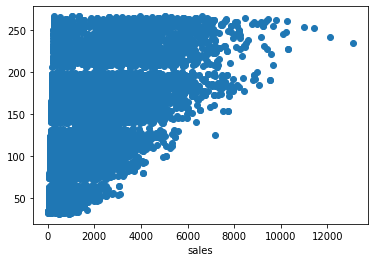

In [235]:
plt.scatter(data['Item_Outlet_Sales'], data['Item_MRP'])
plt.xlabel('sales')
plt.show()

So, we need to process categorical features to get more information about correlation in data

In [0]:
# let`s use label encoder for processing categorical features
le = LabelEncoder()

In [0]:
data['Item_Fat_Content'] = le.fit_transform(data['Item_Fat_Content'])
data['Item_Type'] = le.fit_transform(data['Item_Type'])
data['Outlet_Size'] = le.fit_transform(data['Outlet_Size'])
data['Outlet_Location_Type'] = le.fit_transform(data['Outlet_Location_Type'])
data['Outlet_Type'] = le.fit_transform(data['Outlet_Type'])
data['Outlet_Establishment_Year'] = le.fit_transform(data['Outlet_Establishment_Year'])

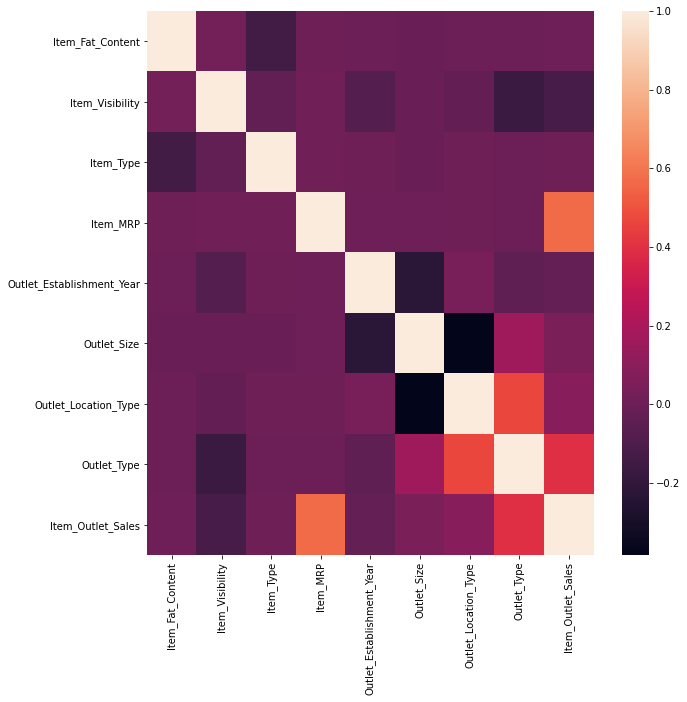

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr())

So, let`s try to build up the models: Linearregression and RandomForrest. Im going to use MAE - mean absolute error to evaluate model results because we will predict sales numbers, this is continuous values.

In [0]:
data_scal = data[['Item_MRP', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']]
headers = data_scal.columns

In [0]:
scaler = StandardScaler()
data_scal = scaler.fit_transform(data_scal)

In [0]:
data_scal = pd.DataFrame(data_scal)
data_scal.columns = headers

In [0]:
# for linear model I will leave only three feature which have the largest data correlation
X = data_scal[['Item_MRP', 'Outlet_Location_Type', 'Outlet_Type']]
y = data_scal['Item_Outlet_Sales']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
prediction_lin = model_lin.predict(X_test)

In [24]:
model_lin.score(X_test, y_test)

0.5037188834241534

In [25]:
print("MAE: \t", mean_absolute_error(y_test, prediction_lin))

MAE: 	 0.5371528719110639


In [0]:
# for i, j in zip(y_test, prediction_lin):
#     print('target:', i, 'pred:', j)

In [26]:
# let`s try polynomial regression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)
# prediction_poly = model_lin.predict(X_poly)
pol_reg.score(poly_reg.fit_transform(X_test), y_test)

0.6074349399973495

In [0]:
print("MAE: \t", mean_absolute_error(y_test, prediction_lin))

In [48]:
data_proba = data[data['Item_Outlet_Sales']<= 5000] 
data_proba.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,1,0.016047,4,249.8092,OUT049,4,2,0,1,3735.1380
1,DRC01,5.92,2,0.019278,14,48.2692,OUT018,8,2,2,2,443.4228
2,DRC01,5.92,2,0.019278,14,48.2692,OUT018,8,2,2,2,443.4228
3,FDN15,17.5,1,0.016760,10,141.6180,OUT049,4,2,0,1,2097.2700
4,FDX07,19.2,2,0.000000,6,182.0950,OUT010,3,0,2,0,732.3800


In [0]:
# two times
data_proba = data_proba.sort_values(by='Item_Outlet_Sales',ascending=True).reset_index()

In [0]:
data_proba = data_proba.drop('index', axis=1)

In [0]:
data_proba = data_proba.applymap(lambda x: int(x) if isinstance(x, float) else x)

In [0]:
data_proba.loc[:2888, 'level_0'] = '1'
data_proba.loc[2888:5403, 'level_0'] = '2'
data_proba.loc[5404:7234, 'level_0'] = '3'
data_proba.loc[7234:8434, 'level_0'] = '4'
data_proba.loc[8434:, 'level_0'] = '5'

In [171]:
data_proba

,level_0,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1,NCR42,9,1,0,9,33,OUT010,3,0,2,0,33
1,1,DRK12,9,1,0,14,32,OUT010,3,0,2,0,33
2,1,DRK12,9,1,0,14,32,OUT010,3,0,2,0,33
3,1,FDU21,17,2,0,13,35,OUT019,0,3,0,0,33
4,1,NCL41,11,1,0,8,34,OUT019,0,3,0,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9105,5,FDK40,7,0,0,5,263,OUT049,4,2,0,1,4996
9106,5,FDF39,14,2,0,4,262,OUT046,2,3,0,1,4996
9107,5,FDF05,17,1,0,5,264,OUT013,1,1,2,1,4996
9108,5,FDU01,20,2,0,3,184,OUT046,2,3,0,1,4997


In [0]:
X_1 = data_proba.drop(['level_0', 'Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'], axis=1)
y_1 = data_proba['level_0']

In [0]:
X_1train, X_1test, y_1train, y_1test = train_test_split(X_1, y_1, test_size=0.3)

In [0]:
dt = DecisionTreeClassifier(min_samples_split=236)

In [251]:
dt.fit(X_1train, y_1train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=236,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

''

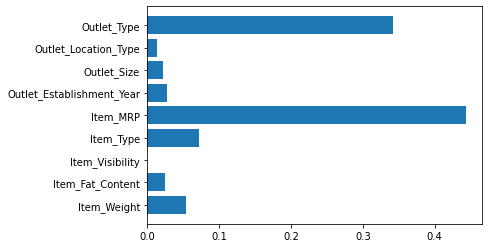

In [248]:
# the most important features
plt.barh(np.arange(len(dt.feature_importances_)), dt.feature_importances_)
plt.yticks(np.arange(len(X_1.columns)),X_1.columns)
''

In [252]:
dt.score(X_1test, y_1test)

0.500182949140139

In [255]:
dt.predict(X_1test)

array(['4', '1', '3', ..., '2', '1', '1'], dtype=object)

In [0]:
a=[]
for i, j in zip(y_1train, dt.predict(X_1test)):
    a.append(int(i)- int(j))
    # print('target:', i, 'pred:', j, 'diff: ', int(i)- int(j))

In [0]:
b = pd.DataFrame(a)
b.reset_index()

In [0]:
b.columns=['1']

In [283]:
b['1'].value_counts()

 0    634
-1    543
 1    508
-2    298
 2    292
-3    194
 3    148
 4     70
-4     46
Name: 1, dtype: int64

In [257]:
yval_pred_proba = dt.predict_proba(X_1test)
yval_pred_proba

array([[0.00775194, 0.10852713, 0.20930233, 0.3875969 , 0.28682171],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.16666667, 0.31666667, 0.34166667, 0.16666667, 0.00833333],
       ...,
       [0.0326087 , 0.59782609, 0.30434783, 0.04347826, 0.02173913],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.52222222, 0.42222222, 0.05555556, 0.        , 0.        ]])